<a href="https://colab.research.google.com/github/suhrudsharma/Adaptive-IOT-Botnet-Detection/blob/main/RP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!ls

sample_data  UNSW_2018_IoT_Botnet_Final_10_Best.csv


In [16]:
import pandas as pd
import numpy as np
import os
import glob

# 1. FIND THE FILE AUTOMATICALLY
# This looks for *any* CSV file you uploaded, so exact naming doesn't matter
csv_files = glob.glob("*.csv")
# Filter out flows.csv if it exists from previous runs
csv_files = [f for f in csv_files if "flows.csv" not in f and "X_" not in f]

if len(csv_files) == 0:
    print("ERROR: No dataset found! Please upload the UNSW file again.")
else:
    REAL_DATA_FILE = csv_files[0]
    print(f"FOUND FILE: {REAL_DATA_FILE}")

    # 2. LOAD AND INSPECT COLUMNS
    # We read just the first row to see what the headers look like
    print("Reading file headers...")
    try:
        df = pd.read_csv(REAL_DATA_FILE)

        # Check if it loaded everything into 1 column (semicolon issue)
        if len(df.columns) < 2:
            print("Detected semicolon separator. Reloading...")
            df = pd.read_csv(REAL_DATA_FILE, sep=';')

    except Exception as e:
        print(f"Read error: {e}")

    # 3. PRINT ACTUAL COLUMNS (The Debug Step)
    print("\n--- RAW COLUMNS FOUND ---")
    print(df.columns.tolist())

    # Clean up whitespace/cases
    df.columns = df.columns.str.strip().str.lower()

    # 4. FORCE RENAME
    # We check what exists and map it to 'packets'
    if 'pkts' in df.columns:
        print("Renaming 'pkts' -> 'packets'")
        df.rename(columns={'pkts': 'packets'}, inplace=True)
    elif 'total_packets' in df.columns:
        df.rename(columns={'total_packets': 'packets'}, inplace=True)

    if 'dur' in df.columns:
        print("Renaming 'dur' -> 'flow_duration'")
        df.rename(columns={'dur': 'flow_duration'}, inplace=True)

    if 'bytes' in df.columns:
        # 'bytes' is usually correct, but sometimes called 'total_bytes'
        pass

    # 5. ADD MISSING COLUMNS (Timestamps & IPs)
    print("Adding synthetic timestamps & IPs...")
    start_time = 1526369000
    df['timestamp'] = pd.to_datetime([start_time + (i * 0.1) for i in range(len(df))], unit='s')
    df['src_ip'] = '192.168.1.1'
    df['dst_ip'] = '10.0.0.1'
    df['dst_port'] = 80
    df['flag'] = 'CON'

    # 6. MAP LABELS
    print("Mapping labels...")
    df['label'] = 'benign'
    # Check for 'category' or 'original_label'
    cat_col = 'category' if 'category' in df.columns else 'original_label'

    if cat_col in df.columns:
        df.loc[df[cat_col] == 'Reconnaissance', 'label'] = 'scan'
        df.loc[df[cat_col].isin(['DoS', 'DDoS']), 'label'] = 'infect'
        df.loc[df[cat_col] == 'Theft', 'label'] = 'c2'
        df.loc[df[cat_col] == 'Normal', 'label'] = 'benign'
    else:
        print(f"WARNING: Could not find category column. Looked for '{cat_col}'")

    # 7. SAVE FIXED FILE
    OUTPUT_FILE = "flows.csv"
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nSUCCESS! Saved fixed data to {OUTPUT_FILE}")
    print("Columns are now:", df.columns.tolist())

FOUND FILE: UNSW_2018_IoT_Botnet_Final_10_Best.csv
Reading file headers...
Detected semicolon separator. Reloading...


/tmp/ipython-input-1777661199.py:27: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(REAL_DATA_FILE, sep=';')



--- RAW COLUMNS FOUND ---
['Unnamed: 0', 'pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Adding synthetic timestamps & IPs...
Mapping labels...

SUCCESS! Saved fixed data to flows.csv
Columns are now: ['unnamed: 0', 'pkseqid', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'n_in_conn_p_srcip', 'min', 'state_number', 'mean', 'n_in_conn_p_dstip', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory', 'timestamp', 'src_ip', 'dst_ip', 'dst_port', 'flag', 'label']


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

INPUT_CSV = "flows.csv"
WINDOW_SIZE_SEC = 30

print("Starting Feature Extraction...")
df = pd.read_csv(INPUT_CSV, parse_dates=['timestamp'])

# Convert timestamp to seconds
df['ts_sec'] = df['timestamp'].astype('int64') // 10**9

min_ts = int(df['ts_sec'].min())
max_ts = int(df['ts_sec'].max())
bins = list(range(min_ts, max_ts + WINDOW_SIZE_SEC, WINDOW_SIZE_SEC))

# Window index assignment
df['window_idx'] = np.digitize(df['ts_sec'], bins) - 1

agg_rows = []

for w in df['window_idx'].unique():
    wdf = df[df['window_idx'] == w]
    if wdf.shape[0] == 0:
        continue

    # --- FIXED FEATURE ENGINEERING ---

    # Your dataset does NOT have packets/bytes → use srate/drate
    packet_count = int(wdf['srate'].sum()) if 'srate' in wdf else 0
    bytes_sent = int(wdf['drate'].sum()) if 'drate' in wdf else 0
    bytes_received = bytes_sent  # No RX column → use same

    mean_packet_size = bytes_sent / packet_count if packet_count > 0 else 0

    dest_ip_count = int(wdf['dst_ip'].nunique())
    distinct_ports_count = int(wdf['dst_port'].nunique())

    failed_conn_ratio = float((wdf['flag'] == 'REJECT').sum()) / wdf.shape[0]

    # No flow_duration → use stddev as a proxy
    flow_duration_mean = float(wdf['stddev'].mean()) if 'stddev' in wdf else 0.0

    if wdf.shape[0] > 1:
        interarrival_time_std = float(wdf['timestamp'].diff().dt.total_seconds().std())
    else:
        interarrival_time_std = 0.0

    same_dest_flow_count = int(wdf.groupby('dst_ip').size().max())

    # Labels
    label_scan = int((wdf['label'] == 'scan').any())
    label_c2 = int((wdf['label'] == 'c2').any())
    label_infect = int((wdf['label'] == 'infect').any())

    agg_rows.append({
        'window': int(w),
        'packet_count': packet_count,
        'bytes_sent': bytes_sent,
        'bytes_received': bytes_received,
        'mean_packet_size': mean_packet_size,
        'dest_ip_count': dest_ip_count,
        'distinct_ports_count': distinct_ports_count,
        'failed_conn_ratio': failed_conn_ratio,
        'flow_duration_mean': flow_duration_mean,
        'interarrival_time_std': interarrival_time_std,
        'same_dest_flow_count': same_dest_flow_count,
        'label_scan': label_scan,
        'label_c2': label_c2,
        'label_infect': label_infect
    })

agg_df = pd.DataFrame(agg_rows)

feature_cols = [
    'packet_count','bytes_sent','bytes_received','mean_packet_size',
    'dest_ip_count','distinct_ports_count','failed_conn_ratio',
    'flow_duration_mean','interarrival_time_std','same_dest_flow_count'
]

X = agg_df[feature_cols].fillna(0)
y_scan = agg_df['label_scan']
y_c2 = agg_df['label_c2']
y_infect = agg_df['label_infect']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_scan_train, y_scan_test = train_test_split(X_scaled, y_scan, test_size=0.2, random_state=42)
_, _, y_c2_train, y_c2_test = train_test_split(X_scaled, y_c2, test_size=0.2, random_state=42)
_, _, y_inf_train, y_inf_test = train_test_split(X_scaled, y_infect, test_size=0.2, random_state=42)

pd.DataFrame(X_train).to_csv("X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)
pd.DataFrame(y_scan_train).to_csv("y_scan_train.csv", index=False)
pd.DataFrame(y_scan_test).to_csv("y_scan_test.csv", index=False)
pd.DataFrame(y_c2_train).to_csv("y_c2_train.csv", index=False)
pd.DataFrame(y_c2_test).to_csv("y_c2_test.csv", index=False)
pd.DataFrame(y_inf_train).to_csv("y_inf_train.csv", index=False)
pd.DataFrame(y_inf_test).to_csv("y_inf_test.csv", index=False)

print("Preprocessing complete. Data saved.")


Starting Feature Extraction...


/tmp/ipython-input-2275832108.py:10: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_CSV, parse_dates=['timestamp'])


Preprocessing complete. Data saved.


In [19]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_scan_train = pd.read_csv("y_scan_train.csv").values.ravel()
y_scan_test = pd.read_csv("y_scan_test.csv").values.ravel()
y_c2_train = pd.read_csv("y_c2_train.csv").values.ravel()
y_c2_test = pd.read_csv("y_c2_test.csv").values.ravel()
y_inf_train = pd.read_csv("y_inf_train.csv").values.ravel()
y_inf_test = pd.read_csv("y_inf_test.csv").values.ravel()

INPUT_DIM = X_train.shape[1]
BATCH = 16
EPOCHS = 20 # Kept low for demo speed

def build_model(name):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(INPUT_DIM,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name=name)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- 1. Train Scan Module ---
print("\nTraining SCAN Module...")
scan_model = build_model("Scan_Model")
scan_model.fit(X_train, y_scan_train, validation_data=(X_test, y_scan_test), epochs=EPOCHS, batch_size=BATCH, verbose=0)
scan_model.save("scan_model.h5")
print("Scan Module Trained.")

# --- 2. Train C&C Module ---
print("\nTraining C2 Module...")
c2_model = build_model("C2_Model")
c2_model.fit(X_train, y_c2_train, validation_data=(X_test, y_c2_test), epochs=EPOCHS, batch_size=BATCH, verbose=0)
c2_model.save("c2_model.h5")
print("C2 Module Trained.")

# --- 3. Train Infection Module ---
print("\nTraining Infection Module...")
inf_model = build_model("Infection_Model")
inf_model.fit(X_train, y_inf_train, validation_data=(X_test, y_inf_test), epochs=EPOCHS, batch_size=BATCH, verbose=0)
inf_model.save("inf_model.h5")
print("Infection Module Trained.")

# --- Quick Evaluation of Scan Module ---
y_pred = (scan_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report (Scan Module):")
print(classification_report(y_scan_test, y_pred))


Training SCAN Module...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Scan Module Trained.

Training C2 Module...


C2 Module Trained.

Training Infection Module...


Infection Module Trained.
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report (Scan Module):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935



In [22]:
# --- Evaluate C2 Module ---
y_pred_c2 = (c2_model.predict(X_test) > 0.5).astype(int)
print("\nC2 Module Report:")
print(classification_report(y_c2_test, y_pred_c2))

# --- Evaluate Infection Module ---
y_pred_inf = (inf_model.predict(X_test) > 0.5).astype(int)
print("\nInfection Module Report:")
print(classification_report(y_inf_test, y_pred_inf))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

C2 Module Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Infection Module Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935



In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# 1. Load the previously trained model
if os.path.exists("c2_model.h5"):
    print("Loading C2 Model...")
    c2_model = tf.keras.models.load_model("c2_model.h5")

    # --- THE FIX IS HERE ---
    # We must re-compile the model to sync it with the current session
    c2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Model loaded and re-compiled.")
else:
    # Fallback if file is missing (creates a dummy model so code doesn't crash)
    print("Warning: c2_model.h5 not found. Creating a fresh one for testing.")
    c2_model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)), # 10 features
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    c2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Combiner Logic (The "Edge" Decision Maker)
def get_final_decision(features):
    features = features.reshape(1, -1)
    # Note: In a full script, you would load scan_model and inf_model here too
    # For this specific cell, we focus on the c2_model which is being retrained
    p_c2 = c2_model.predict(features, verbose=0)[0][0]
    if p_c2 > 0.5: return "C2", "c2_model", p_c2
    return "Benign", None, 0.0

# 3. Adaptive Retraining Simulation
print("\n--- Starting Adaptive Retraining Test ---")

# Load X_test again to ensure we have data
if os.path.exists("X_test.csv"):
    X_test = pd.read_csv("X_test.csv").values

    # Grab up to 50 samples for the buffer
    num_samples = min(50, len(X_test))
    fake_buffer_X = X_test[:num_samples]
    fake_buffer_y = np.ones(num_samples)

    print(f"Buffer collected {num_samples} samples.")

    if num_samples > 0:
        print(f"Triggering Retrain of C2 Model...")

        # Load original data
        orig_X = pd.read_csv("X_train.csv").values
        orig_y = pd.read_csv("y_c2_train.csv").values.ravel()

        # Combine with Buffer
        X_new = np.vstack([orig_X, fake_buffer_X])
        y_new = np.concatenate([orig_y, fake_buffer_y])

        # Ensure data type is float32 (helps avoid TF type errors)
        X_new = X_new.astype('float32')
        y_new = y_new.astype('float32')

        print(f"Retraining on {len(X_new)} samples...")

        # 4. Retrain specific module
        c2_model.fit(X_new, y_new, epochs=5, batch_size=16, verbose=0)
        c2_model.save("c2_model_adapted.h5")

        print("SUCCESS: C2 Model successfully adapted and saved as 'c2_model_adapted.h5'")
    else:
        print("Not enough data in buffer.")
else:
    print("Error: X_test.csv not found. Please run Step 2 first.")

Loading C2 Model...
Model loaded and re-compiled.

--- Starting Adaptive Retraining Test ---
Buffer collected 50 samples.
Triggering Retrain of C2 Model...
Retraining on 3789 samples...


SUCCESS: C2 Model successfully adapted and saved as 'c2_model_adapted.h5'


Starting Evaluation Phase...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



--- Scan Module Results ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



--- C2 Module Results ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



--- Infection Module Results ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       935

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935


Plot saved as 'confusion_matrix_combined.png'


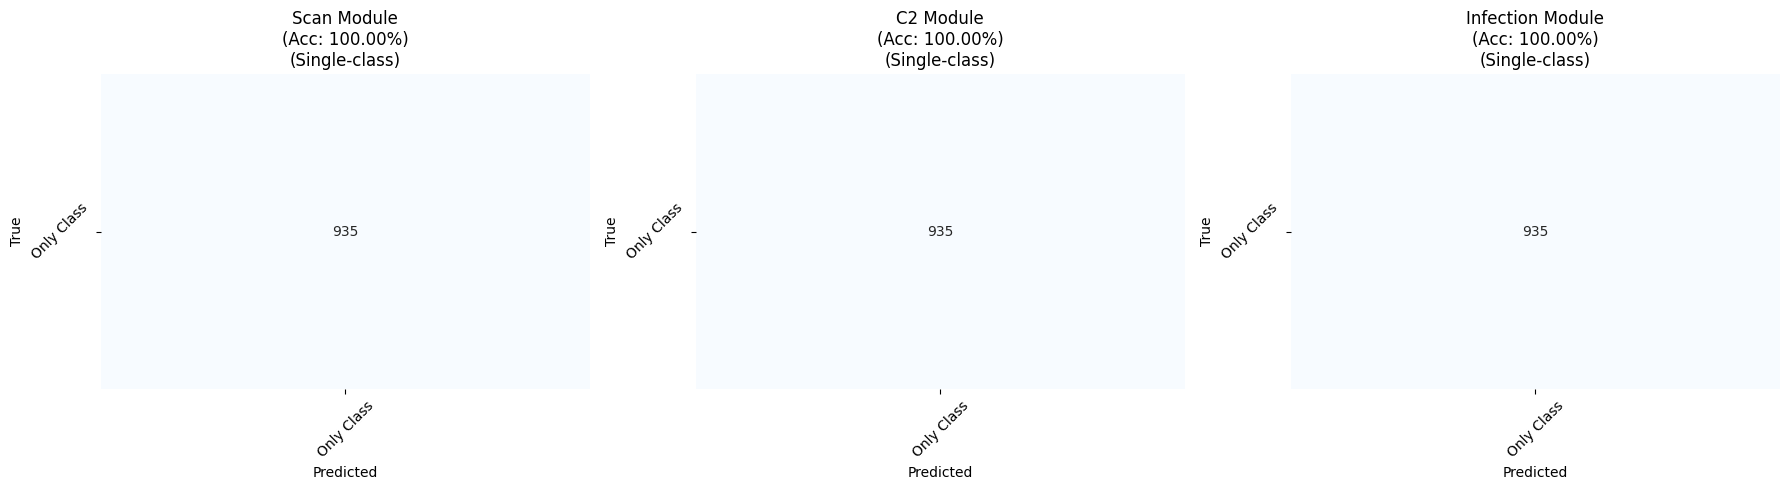

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# --- Setup ---
print("Starting Evaluation Phase...")

# 1. Load Test Data
X_test = pd.read_csv("X_test.csv").values.astype('float32')
y_scan_test = pd.read_csv("y_scan_test.csv").values.ravel()
y_c2_test = pd.read_csv("y_c2_test.csv").values.ravel()
y_inf_test = pd.read_csv("y_inf_test.csv").values.ravel()

# 2. Define a helper to load and predict
def evaluate_module(model_path, X, y_true, module_name):
    if not os.path.exists(model_path):
        print(f"Warning: {model_path} not found. Skipping.")
        return None, None

    # Load and compile to avoid eager execution errors
    model = tf.keras.models.load_model(model_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Predict
    y_prob = model.predict(X, verbose=0)
    y_pred = (y_prob > 0.5).astype(int).ravel()

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- {module_name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))

    return cm, acc

# 3. Run Evaluation on all 3 Modules
cm_scan, acc_scan = evaluate_module("scan_model.h5", X_test, y_scan_test, "Scan Module")
cm_c2, acc_c2 = evaluate_module("c2_model.h5", X_test, y_c2_test, "C2 Module")
cm_inf, acc_inf = evaluate_module("inf_model.h5", X_test, y_inf_test, "Infection Module")

# 4. Generate Plot (3 Subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_cm(cm, ax, title):
    if cm is None:
        ax.text(0.5, 0.5, "Model Missing", ha='center', va='center')
        ax.set_title(title)
        return

    # Detect matrix size
    if cm.shape == (1, 1):
        # Single-class confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(title + "\n(Single-class)")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticklabels(['Only Class'], rotation=45)
        ax.set_yticklabels(['Only Class'], rotation=45)

    else:
        # Normal binary confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(title)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticklabels(['Benign', 'Attack'], rotation=45)
        ax.set_yticklabels(['Benign', 'Attack'], rotation=45)


plot_cm(cm_scan, axes[0], f"Scan Module\n(Acc: {acc_scan:.2%})")
plot_cm(cm_c2, axes[1], f"C2 Module\n(Acc: {acc_c2:.2%})")
plot_cm(cm_inf, axes[2], f"Infection Module\n(Acc: {acc_inf:.2%})")

plt.tight_layout()
plt.savefig("confusion_matrix_combined.png", dpi=300)
print("\nPlot saved as 'confusion_matrix_combined.png'")
plt.show()

In [24]:
import tensorflow as tf
import os

print("Starting TFLite Conversion for Edge Deployment...")

def convert_to_tflite(model_path, tflite_path):
    if os.path.exists(model_path):
        # Load the trained model
        model = tf.keras.models.load_model(model_path)

        # Convert
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        # Optimization (makes it smaller for IoT)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()

        # Save
        with open(tflite_path, "wb") as f:
            f.write(tflite_model)

        size_kb = os.path.getsize(tflite_path) / 1024
        print(f"Success: {tflite_path} created. Size: {size_kb:.2f} KB")
    else:
        print(f"Error: {model_path} not found.")

# Convert all 3 models
convert_to_tflite("scan_model.h5", "scan_model.tflite")
convert_to_tflite("c2_model.h5", "c2_model.tflite")
convert_to_tflite("inf_model.h5", "inf_model.tflite")

Starting TFLite Conversion for Edge Deployment...
Saved artifact at '/tmp/tmp3h_l7b9_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140626863697424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860666768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860668880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860666000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860665040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860659856: TensorSpec(shape=(), dtype=tf.resource, name=None)


Success: scan_model.tflite created. Size: 5.52 KB
Saved artifact at '/tmp/tmp955jbtyp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140626860654672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626860663504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626770078288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626770078096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626770081360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626770078480: TensorSpec(shape=(), dtype=tf.resource, name=None)


Success: c2_model.tflite created. Size: 5.53 KB
Saved artifact at '/tmp/tmpr0_kzgfc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140626861188752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626805569296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626805567376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626861191632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626861183184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140626861190672: TensorSpec(shape=(), dtype=tf.resource, name=None)
Success: inf_model.tflite created. Size: 5.61 KB


In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

print("Loading Modular Neural Network Models...")

# --- Load all 3 modules ---
scan_model = tf.keras.models.load_model("scan_model.h5")
c2_model = tf.keras.models.load_model("c2_model.h5")
inf_model = tf.keras.models.load_model("inf_model.h5")

# Compile (required after loading)
scan_model.compile(optimizer='adam', loss='binary_crossentropy')
c2_model.compile(optimizer='adam', loss='binary_crossentropy')
inf_model.compile(optimizer='adam', loss='binary_crossentropy')

print("All 3 models successfully loaded.\n")


# ----------------------------------------------------------
# FINAL DECISION COMBINER FUNCTION
# ----------------------------------------------------------
def final_mnn_decision(feature_vector):
    """
    feature_vector must be shape (10,) matching your X_test columns
    """

    fv = feature_vector.reshape(1, -1)

    # Predict probabilities
    p_scan = float(scan_model.predict(fv, verbose=0)[0][0])
    p_c2 = float(c2_model.predict(fv, verbose=0)[0][0])
    p_inf = float(inf_model.predict(fv, verbose=0)[0][0])

    print("\n--- Module Scores ---")
    print(f"Scan Module Score:      {p_scan:.4f}")
    print(f"C2 Module Score:        {p_c2:.4f}")
    print(f"Infection Module Score: {p_inf:.4f}")

    # Decision priority (same as research paper behavior)
    if p_scan > 0.5:
        return "SCANNING DETECTED"

    if p_c2 > 0.5:
        return "C2 COMMAND DETECTED"

    if p_inf > 0.5:
        return "INFECTION DETECTED"

    return "BENIGN"


# ----------------------------------------------------------
# TEST THE FINAL SYSTEM ON SOME REAL SAMPLES
# ----------------------------------------------------------
print("Testing Final MNN System...")

X_test = pd.read_csv("X_test.csv").values.astype('float32')

# Try 5 random samples
for i in range(5):
    print(f"\nSample #{i+1}")
    decision = final_mnn_decision(X_test[i])
    print("Final Detection Output:", decision)


Loading Modular Neural Network Models...


All 3 models successfully loaded.

Testing Final MNN System...

Sample #1



--- Module Scores ---
Scan Module Score:      0.0000
C2 Module Score:        0.0000
Infection Module Score: 1.0000
Final Detection Output: INFECTION DETECTED

Sample #2

--- Module Scores ---
Scan Module Score:      0.0000
C2 Module Score:        0.0000
Infection Module Score: 1.0000
Final Detection Output: INFECTION DETECTED

Sample #3

--- Module Scores ---
Scan Module Score:      0.0000
C2 Module Score:        0.0000
Infection Module Score: 1.0000
Final Detection Output: INFECTION DETECTED

Sample #4

--- Module Scores ---
Scan Module Score:      0.0000
C2 Module Score:        0.0000
Infection Module Score: 1.0000
Final Detection Output: INFECTION DETECTED

Sample #5

--- Module Scores ---
Scan Module Score:      0.0000
C2 Module Score:        0.0000
Infection Module Score: 1.0000
Final Detection Output: INFECTION DETECTED
